In [1]:
import sys
sys.path.append("/home/wanxinli/EHR-OT/")

from ast import literal_eval
import collections
from mimic_common import *
import os
import pandas as pd
from statistics import mean, stdev

In [2]:
def read_df(group_name, group_1, group_2, suffix = None):
    """ 
    Absoluate bound for filtering out ratios
    """
    target_equity_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_equity.csv")
    if suffix is not None:
        target_equity_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_{suffix}_equity.csv")
    target_equity_df = pd.read_csv(target_equity_path, header=0, index_col=None, converters={'target_codes': literal_eval})

    return target_equity_df

In [3]:
def find_outlier_codes(df):
    """ 
    :param Dataframe df: the read in dataframe

    Find outlier admissions' codes
    """
    diff_percents = list(df['target_diff_percent'])
    thres = mean(diff_percents)+3*stdev(diff_percents)

    outlier_codes = []
    for _, row in df.iterrows():
        if abs(row['target_diff_percent']) > thres:
            outlier_codes.append(row['target_codes'])
    return outlier_codes
    

In [4]:
def determine_code_freq(outlier_codes, occur_percent = 0.2):
    """ 
    Determine code frequencies for codes in outlier_codes
    :param float occur_percent: the percentage out of all outlier admissions to be classified as outlier code
    """
    num_adm = len(outlier_codes)
    outlier_codes = [code for code_vec in outlier_codes for code in code_vec]
    code_freq = collections.Counter(outlier_codes)
    code_freq = dict(sorted(code_freq.items(), key=lambda item: item[1], reverse=True))

    code_freq = {key: value for key, value in code_freq.items() if key != '' and value > occur_percent*num_adm}
    return code_freq


In [5]:
def entire_proc(group_name, group_1, group_2):
    df = read_df(group_name, group_1, group_2)
    outlier_codes = find_outlier_codes(df)
    code_freq = determine_code_freq(outlier_codes)
    for code, freq in code_freq.items():
        chapter_num, chapter_name = decide_ICD_chapter(code)
        title = get_code_title(code)
        print(f"ICD code: {code}, chapter number: {chapter_num}, chapter name: {chapter_name}, code title: {title}")
    return code_freq.keys()


In [6]:
suffix = None
group_name = 'insurance'
groups = ['Self_Pay', 'Private', 'Government', 'Medicare', 'Medicaid']
outlier_codes = []

for i, group_1 in enumerate(groups):
    for j, group_2 in enumerate(groups):
        print(f"group 1 is: {group_1}, group_2 is: {group_2}")
        if i <= j:
            continue
        outlier_codes.extend(entire_proc(group_name, group_1, group_2))

print("========= printing outlier codes =============")
outlier_code_dict = dict(Counter(outlier_codes))
for code, freq in outlier_code_dict.items():
    chapter_num, chapter_name = decide_ICD_chapter(code)
    title = get_code_title(code)
    freq = freq/(len(groups)*(len(groups)-1)/2)
    print(f"ICD code: {code}, chapter number: {chapter_num}, chapter name: {chapter_name}, code title: {title}, frequency: {freq}")

group 1 is: Self_Pay, group_2 is: Self_Pay
group 1 is: Self_Pay, group_2 is: Private
group 1 is: Self_Pay, group_2 is: Government
group 1 is: Self_Pay, group_2 is: Medicare
group 1 is: Self_Pay, group_2 is: Medicaid
group 1 is: Private, group_2 is: Self_Pay
ICD code: 807.09, chapter number: 17, chapter name: Injury and Poisoning, code title: Fx mult ribs NOS-closed
ICD code: 861.21, chapter number: 17, chapter name: Injury and Poisoning, code title: Lung contusion-closed
ICD code: 427.5, chapter number: 7, chapter name: Diseases of the Circulatory System, code title: Cardiac arrest
ICD code: E849.5, chapter number: 18, chapter name: Supplementary Classification of External Causes of Injury and Poisoning, code title: Accid on street/highway
ICD code: 864.14, chapter number: 17, chapter name: Injury and Poisoning, code title: Liver lacerat, major-opn
ICD code: 276.2, chapter number: 3, chapter name: Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders, code title: Acidos

In [25]:
suffix = None
group_name = 'marital_status'
groups = ['SEPARATED', 'DIVORCED', 'MARRIED','WIDOWED', 'SINGLE']
outlier_codes = []

for i, group_1 in enumerate(groups):
    for j, group_2 in enumerate(groups):
        print(f"group 1 is: {group_1}, group_2 is: {group_2}")
        if i <= j:
            continue
        outlier_codes.extend(entire_proc(group_name, group_1, group_2))

print("========= printing outlier codes =============")
outlier_code_dict = dict(Counter(outlier_codes))
chapter_code_dict = {}
for code, freq in outlier_code_dict.items():
    chapter_num, chapter_name = decide_ICD_chapter(code)
    title = get_code_title(code)
    freq = freq/(len(groups)*(len(groups)-1)/2)
    if chapter_num not in chapter_code_dict:
        chapter_code_dict[chapter_num] = {'chapter_name': chapter_name, 'code': [], 'title': [], 'freq': []} # code, code titles and frequencies 
    chapter_code_dict[chapter_num]['code'].append(f'{code}: {title}')
    chapter_code_dict[chapter_num]['freq'].append(freq)
    print(f"ICD code: {code}, chapter number: {chapter_num}, chapter name: {chapter_name}, code title: {title}, frequency: {freq}")

chapter_code_dict = dict(sorted(chapter_code_dict.items()))

group 1 is: SEPARATED, group_2 is: SEPARATED
group 1 is: SEPARATED, group_2 is: DIVORCED
group 1 is: SEPARATED, group_2 is: MARRIED
group 1 is: SEPARATED, group_2 is: WIDOWED
group 1 is: SEPARATED, group_2 is: SINGLE
group 1 is: DIVORCED, group_2 is: SEPARATED
ICD code: 427.31, chapter number: 7, chapter name: Diseases of the Circulatory System, code title: Atrial fibrillation
ICD code: 403.90, chapter number: 7, chapter name: Diseases of the Circulatory System, code title: Hy kid NOS w cr kid I-IV
ICD code: 585.9, chapter number: 10, chapter name: Diseases of the Genitourinary System, code title: Chronic kidney dis NOS
ICD code: 403.91, chapter number: 7, chapter name: Diseases of the Circulatory System, code title: Hyp kid NOS w cr kid V
ICD code: 401.9, chapter number: 7, chapter name: Diseases of the Circulatory System, code title: Hypertension NOS
ICD code: 285.9, chapter number: 4, chapter name: Diseases of the Blood and Blood-forming Organs, code title: Anemia NOS
ICD code: 428.

[0]
[1 2]
[3]
[4 5 6]
[ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[22 23 24 25]
[26 27 28]
[29 30]
[31 32]
[33]
[34]


AttributeError: 'bool' object has no attribute 'size'

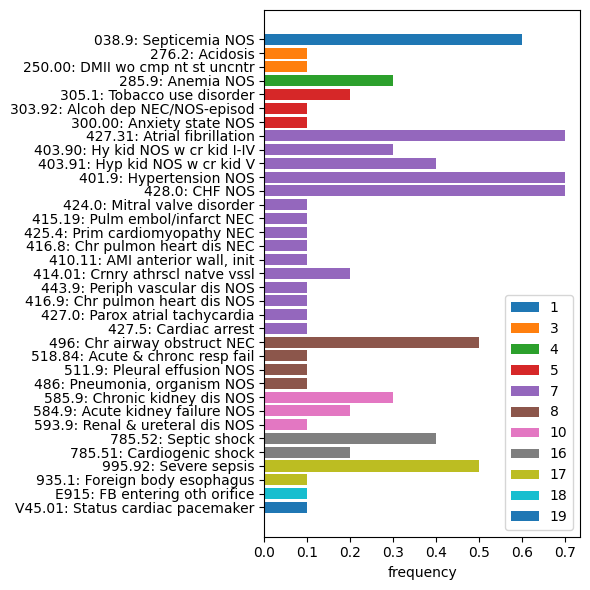

In [27]:
plt.figure(figsize=(6,6))

ax = plt.axes()

prev_code_len = 0
for chapter_num in chapter_code_dict.keys():
    codes = chapter_code_dict[chapter_num]['code']
    # plt.figure(figsize=(6, 0.3*len(codes)))
    # pos = np.arange(len(chapter_code_dict[chapter_num]['code']))
    y_pos = np.arange(prev_code_len, prev_code_len+len(codes), 1)
    print(y_pos)
    prev_code_len += len(codes)
    freqs = chapter_code_dict[chapter_num]['freq']

    ax.barh(codes, freqs, align='center', label=chapter_num)
    # ax.set_yticks(y_pos)
    ax.invert_yaxis()  # labels read top-to-bottom

    # plt.tight_layout()
    # plt.savefig(fig_path, bbox_inches='tight')

ax.set_xlabel('frequency')
ax.tick_params(axis='y', labelsize=10)

# ax.set_title(f'Chapter {chapter_num}: {chapter_code_dict[chapter_num]["chapter_name"]}')
plt.xticks(np.arange(0, 0.8, 0.1))
plt.legend()

fig_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_by_chapter_outlier_code.pdf")
plt.tight_layout()
plt.savefig(fig_path, bbox_inches='tight')
plt.show()



In [9]:
chapter_code_dict 

{7: {'chapter_name': 'Diseases of the Circulatory System',
  'code': ['427.31: Atrial fibrillation',
   '403.90: Hy kid NOS w cr kid I-IV',
   '403.91: Hyp kid NOS w cr kid V',
   '401.9: Hypertension NOS',
   '428.0: CHF NOS',
   '424.0: Mitral valve disorder',
   '415.19: Pulm embol/infarct NEC',
   '425.4: Prim cardiomyopathy NEC',
   '416.8: Chr pulmon heart dis NEC',
   '410.11: AMI anterior wall, init',
   '414.01: Crnry athrscl natve vssl',
   '443.9: Periph vascular dis NOS',
   '416.9: Chr pulmon heart dis NOS',
   '427.0: Parox atrial tachycardia',
   '427.5: Cardiac arrest'],
  'title': [],
  'freq': [0.7,
   0.3,
   0.4,
   0.7,
   0.7,
   0.1,
   0.1,
   0.1,
   0.1,
   0.1,
   0.2,
   0.1,
   0.1,
   0.1,
   0.1]},
 10: {'chapter_name': 'Diseases of the Genitourinary System',
  'code': ['585.9: Chronic kidney dis NOS',
   '584.9: Acute kidney failure NOS',
   '593.9: Renal & ureteral dis NOS'],
  'title': [],
  'freq': [0.3, 0.2, 0.1]},
 4: {'chapter_name': 'Diseases of t